### 1. Contextual Attention
**提出**：上下文注意力，CVPR——18 ： Generative image inpainting with contextual attention.\
上下文注意力的核心是使用已知Patch作为卷积滤波器来处理生成patch\
**作用**：允许在修复过程中长记录空间依赖，能够从远处位置借用像素来填补缺失区域。，上下文注意力层有两个阶段：match 、 attention，"match"阶段通过获取孔内和孔外的patch之间的区域亲和度来计算注意力分数；"attention"阶段根据注意力分数复制、聚合加权的上下文patch来填充空洞。\
**方案**：如图所示，首先在背景中提取3x3的patch，然后将其重塑为卷积滤波器，为了匹配前景区域patch$\{f_{x,y}\}$和背景区域$\{b_{x^`, y^`}\}$，我们使用归一化内积（余弦相似度）计算：
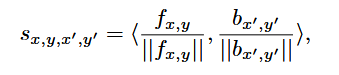\
然后使用缩放的softmax沿着$x^`y^`$方向加权相似度以获得每个像素的注意力分数\
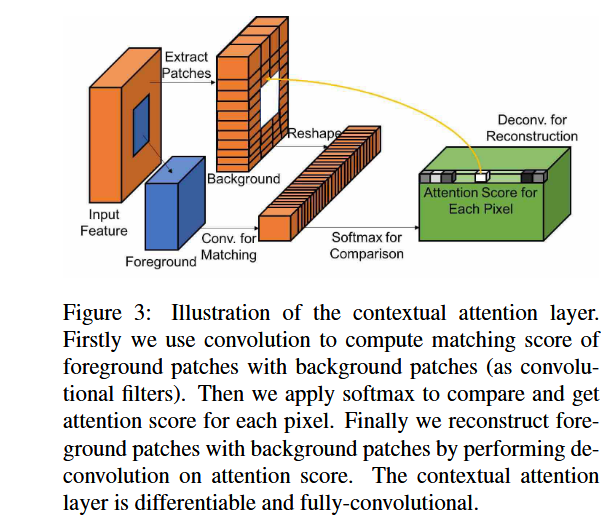
#### 1.1 代码实现

In [ ]:
# pytorch实现，原论文为tensorflow实现
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def resize_tensor(tensor, scale=None, size=None, mode='nearest'):
    pass

def extract_patches_efficient():
    pass

def flow_to_image_torch():
    pass
def contextual_attention(f, b, mask=None, ksize=3, stride=1, rate=1, fuse_k=3, softmax_scale=10, training=True, fuse=True):
    """
    Args:
        f:用于匹配的输入特征（前景）（B, C, H, W)
        b:用于匹配的输入特征（背景）（B，C，H，W)
        mask: b的输入掩码，指示不可用的补丁（B，1，H，W)
        ksize:上下文注意力的核大小
        stride:从b中提取patch的步长
        rate:匹配时的膨胀率
        fuse_k:融合核大小
        softmax_scale:注意力缩放的softmax参数
        training:训练还是推理
        fuse:是否使用融合操作
    Returns:
        output:输出张量（B，C，H，W）
        flow:光流可视化（B，3，H，W）
    """
    device = f.device
    # 获取原始形状
    B, C, H_f, W_f = f.shape
    _, _, H_b, W_b = b.shape
    raw_shape = b.shape
     #  1.提取用于重建的原始补丁
    kernel = 2 *rate
    raw_patches, _ = extract_patches_efficient(b, kernel, rate * stride, 1)
    num_raw_patches = raw_patches.shape[2]
    raw_patches = raw_patches.view(B, C, kernel, kernel, num_raw_patches)
    # 2. 下采样处理
    if rate > 1:
        scale_factor = 1.0 / rate
        f = F.interpolate(f, scale_factor=scale_factor, mode='nearest', align_corners=False)
        b = F.interpolate(b, scale_factor=scale_factor, mode='nearest', align_corners=False)
        if mask is not None:
            mask = F.interpolate(mask, scale_factor=scale_factor, mode='nearest', align_corners=False)
    # 更新下采样后的性质
    B, C, H_f_ds, W_f_ds = f.shape
    _, _, H_b_ds, W_b_ds = b.shape
    # 3.从背景区域提取匹配用的补丁
    b_patches, (H_out, W_out) = extract_patches_efficient(b, ksize, stride, 1)
    b_patches = b_patches.view(B, C, ksize * ksize, H_out * W_out)
    # 4.处理掩码
    if mask is None:
        mask = torch.zeros(B, 1, H_b_ds, W_b_ds, device=device)

    # 提取掩码patch
    mask_patches, _ - extract_patches_efficient(mask, ksize, stride, 1)
    mask_patches = mask_patches.view(B, ksize * ksize, H_out * W_out)
    # 计算每个patch平均掩码之，0表示有效patch
    mask_mean = torch.mean(mask_patches, dim=1, keepdim=True)
    valid_mask = (mask_mean == 0.).float()
    # 5. 高效计算注意力分数
    b_patches_norm = F.normalize(b_patches, p=2, dim=1) # L2归一化
    # 重塑前景特征用于卷积计算
    f_unfold, (H_f_out, W_f_out) = extract_patches_efficient(f, ksize, stride=1, dilation=1)
    f_unfold = f_unfold.view(B, C, ksize * ksize, H_f_out, W_f_out)
    f_unfold = F.normalize(f_unfold, p=2, dim=1)
    #
    

### 2. Pyramid Contextual Attention
**提出**：金字塔上下文注意力，CVPR——19：Learning pyramid-context encoder network for highquality image inpainting\
**作用**：

### 3.Contextual Residual Aggregation(CRA) mechanism
**提出**：上下文残差聚合机制，CVPR——20：Contextual Residual Aggregation for Ultra High-REsolution Image Inpainting\
，CRA机制不仅从特征，而且还借用了残差。特别是，我们通过在缺少区域内部/外部的斑块之间获得区域亲和力来计算注意力评分的观念。因此，可以将外部与上下文相关的特征和残差转移到孔中。我们的机制涉及两个关键模块：注意计算模块和注意转移模块